In [1]:
import itertools
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sb

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Считывание хороших и плохих контрактов
bad_cntr = pd.read_csv('../data/yarobl_bad_contracts_plus.csv')
good_cntr = pd.read_csv('../data/yaroblmz_good_contracts.csv')
data = bad_cntr.append(good_cntr)
print(data.shape)

# Сокращение количества хороших контрактов до числа имеющихся плохих
# data = good_cntr.append(bad_cntr.iloc[:good_cntr.shape[0],:])
# print(data.shape)

(11926, 15)


In [3]:
# Первые 5 строк
data.head(5)

,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,price_higher_pmp,price_too_low,cntr_result
0,1573678,871,0.0,0.0,2,189491.0,0.0,1.0,0.50000,0,0.0,0.50000,0,0,0
1,1505114,188,0.0,0.0,22,267789.0,0.0,1.0,1.00000,0,0.0,0.09091,0,0,0
2,1516375,199,0.0,0.0,5,386494.0,0.0,1.0,1.00000,0,0.0,0.20000,0,0,0
3,1603679,52,0.0,0.0,43,272642.0,0.0,1.0,0.18605,0,0.0,0.04651,0,0,0
4,1511046,569,0.0,0.0,47,487732.0,0.0,1.0,0.61702,0,0.0,0.02128,0,1,0


In [4]:
# Удаление строк, в которых есть значение NULL
data = data.dropna()

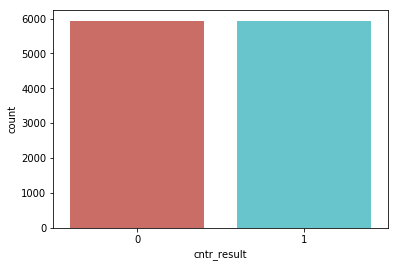

In [5]:
# Количество плохих (0) и хороших контрактов (1)
sb.countplot(x='cntr_result', data=data, palette='hls')

In [6]:
# Разбитие датасета на набор описывающих признаков (X) 
# и соответствущих им предсказываемых величин (у)
X = data.iloc[:,1:-1]
y = data.cntr_result.values

In [7]:
# Описательные статистики атрибутов
X.describe()

,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,price_higher_pmp,price_too_low
count,11862.000000,11862.000000,11862.000000,11862.000000,1.186200e+04,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000,11862.000000
mean,1013.522762,0.000395,0.000043,52.709492,1.404311e+06,0.000083,0.996570,0.851908,0.000422,0.002482,0.369367,0.053448,0.077980
std,1468.801179,0.002894,0.000863,108.972630,2.277167e+07,0.002255,0.034587,0.328467,0.020527,0.044228,0.339632,0.224935,0.268152
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,85.000000,0.000000,0.000000,2.000000,1.329270e+05,0.000000,1.000000,0.980320,0.000000,0.000000,0.111110,0.000000,0.000000
50%,396.000000,0.000000,0.000000,12.000000,2.191050e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.217390,0.000000,0.000000
75%,1260.000000,0.000000,0.000000,52.000000,4.259550e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000
max,6408.000000,0.076920,0.047620,1849.000000,1.303496e+09,0.120910,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Предобработка данных
# Медиана = 1, квадратичное отклонени = 0
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Логистическая регрессия
model = LogisticRegression()

In [10]:
y_train_real = np.array([])
y_test_real = np.array([])

y_train_pred = np.array([])
y_test_pred = np.array([])
y_test_pred_proba = np.zeros((0, 2))

In [11]:
for train_index, test_index in KFold(n_splits=10).split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_real = np.concatenate((y_train_real, y_train))
    y_test_real = np.concatenate((y_test_real, y_test))
    
    y_train_pred = np.concatenate((y_train_pred, model.predict(X_train)))
    y_test_pred = np.concatenate((y_test_pred, model.predict(X_test)))
    y_test_pred_proba = np.concatenate((y_test_pred_proba, model.predict_proba(X_test)))    

In [12]:
# Коэффициенты при объясняющих переменных в порядке возрастания
# Чем больше коэффициент по модулю, тем более значимым он является
sorted(
    dict(
        zip(
            data.iloc[:,1:-1].columns, 
            list(model.coef_[0])
        )
    ).items(),
    key=lambda i: np.absolute(i[1]),
    reverse=True
)

[('sup_okpd_exp', 2.3231316923924163),
 ('sup_1s_org_sev', -1.4221097014884969),
 ('price_higher_pmp', -0.68004761964557681),
 ('sup_no_pnl_share', -0.36685251587583528),
 ('org_cntr_num', 0.29963388849963296),
 ('sup_1s_sev', -0.14531454922030734),
 ('price_too_low', -0.13151011031138679),
 ('sup_cntr_avg_penalty', -0.12650400477908125),
 ('sup_sim_price', -0.051239547433946986),
 ('org_1s_sev', -0.034292182204872478),
 ('sup_cntr_num', -0.030482787348224197),
 ('sup_cntr_avg_price', -0.026921582009582858),
 ('org_1s_sup_sev', 0.01825217860379259)]

In [13]:
print('Точность %s на обучающей выборке' % accuracy_score(y_train_real, y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(y_test_real, y_test_pred))
print('Потеря перекрестной энтропии %s' % log_loss(y_test_real, y_test_pred_proba))

Точность 0.737537233744 на обучающей выборке
Точность 0.708565166077 на тестовой выборке
Потеря перекрестной энтропии 0.604331348954


In [14]:
print(classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')))

             precision    recall  f1-score   support

     Плохой       0.88      0.48      0.62      5926
    Хороший       0.64      0.93      0.76      5936

avg / total       0.76      0.71      0.69     11862



In [15]:
# Таблица для оценки результатов
# result - настоящие статус контракта (0 - плохой, 1 - хороший)
# proba_pred_bad - предсказываемая вероятность плохого исхода контракта
# pred - предсказываемое значение в бинарной шкале
res = pd.DataFrame({'result': y_test_real}).join(
    pd.DataFrame({'proba_pred_bad': y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': y_test_pred})
    )
)
res.head(5)

,result,proba_pred_bad,pred
0,0.0,0.938582,0.0
1,0.0,0.305596,1.0
2,0.0,0.308337,1.0
3,0.0,0.993673,0.0
4,0.0,0.910900,0.0


In [16]:
# Корреляционная матрица
res.corr()

,result,proba_pred_bad,pred
result,1.000000,-0.402965,0.467341
proba_pred_bad,-0.402965,1.000000,-0.921953
pred,0.467341,-0.921953,1.000000


Коэффициент корреляции принимает значение от -1 до 1. 

Корреляция предсказываемой вероятности (proba_pred_bad) и реального статуса (result) контракта есть, но не очень большая. Она отрицательная, так как чем больше вероятность того, что контракт плохой, тем более вероятно, что его настоящий статус (result) равен 0.

Корреляция предсказываемой вероятности (pred) и реального статуса (result) контракта также есть, но не очень большая. Целевое значение я оцениваю от 0,6-0,7.

### Матрица ошибок

In [17]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
    """Функция для построения матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

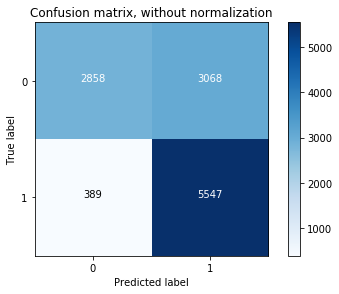

In [18]:
cnf_matrix = confusion_matrix(y_test_real, y_test_pred)
plot_confusion_matrix(
    cnf_matrix, classes=model.classes_, title='Confusion matrix, without normalization'
)

### Кластеризация

Было решено уменьшить размерность пространства до двухмерного. А затем попытаться разделить объекты на 2 класса и визуализировать их на плоскости. Это поможет понять, насколько при текущих данных реально их разделить на 2 класса.

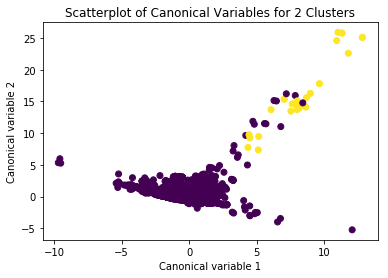

In [19]:
model1 = KMeans(n_clusters=2).fit(X)
plot_columns = PCA(2).fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model1.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

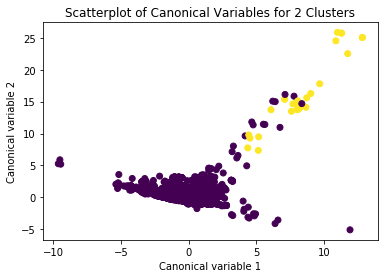

In [20]:
model2 = KMeans(n_clusters=2).fit(X)
plot_columns = PCA(2).fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model2.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

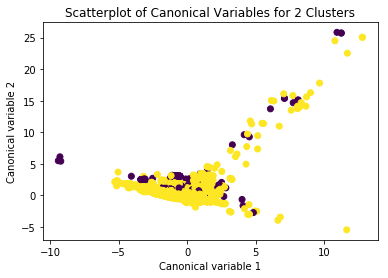

In [21]:
model3 = KMeans(n_clusters=2).fit(X)
plot_columns = PCA(2).fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

Как видно каждый раз разделение на кластеры сильно отличается. Из чего можно предположить, что текущих признаков объектов не хватает для более четкого разделения на 2 класса. 

### Корреляция между предсказываемой вероятностью и реальными данными

In [22]:
counter0 = Counter() # счетчик плохих контрактов
counter1 = Counter() # счетчик хороших контрактов

for index, row in res.iterrows():
    proba = round(row['proba_pred_bad'], 2)
    
    if not row['result']:
        counter0[proba] += 1
    else:
        counter1[proba] += 1

In [23]:
corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])

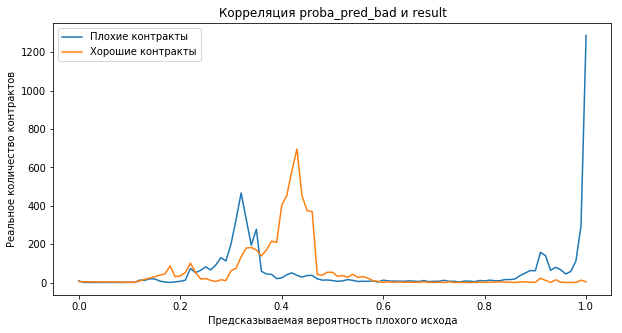

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.plot(corr_df0['index'], corr_df0[0])
ax.plot(corr_df1['index'], corr_df1[0])

plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
plt.xlabel('Предсказываемая вероятность плохого исхода')
plt.ylabel('Реальное количество контрактов')
plt.title('Корреляция proba_pred_bad и result')
plt.show()

### ROC-кривая

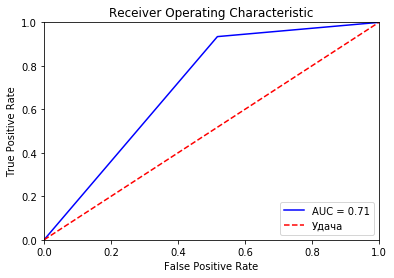

In [25]:
fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label='Удача')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()